# Nutrient analysis of global fisheries II

In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano as T
import theano.tensor as tt
from pymc3.backends import SQLite
import seaborn as sns
import scipy as sp
import pdb

In [2]:
# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

# Helper functions
def indexall_B(L,B):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    a, b = poo.index(B), 0
    poo[b], poo[a] = poo[a], poo[b]
    
    Ix[Ix==b] = -1
    Ix[Ix==a] = 0
    Ix[Ix==-1] = a
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

# Coefficient of variation
cv =  lambda x: np.var(x) / np.mean(x)

## Import data

In [3]:
# Nutritional data
ndata = pd.read_excel('Nutrient_data.xlsx')
# Traits data
tdata = pd.read_excel('Traits_all.xlsx')

In [4]:
# Add traits information to nutritional dataframe
indx = match(ndata.Species_from_search.unique(),list(tdata.species_traits_all.values))
rindx = match(ndata.Species_from_search,list(ndata.Species_from_search.unique()))

# Traits to port over
tmp = ['Class', 'Order', 'Family','Genus_1', 'DemersPelag',
       'EnvTemp', 'DepthRangeDeep', 'trophic_level', 'Feeding_path', 'LMax',
       'BodyShapeI', 'K', 'tm']
# Port over
for trait in tmp:
    ndata[trait] = tdata[trait].values[indx][rindx]

ndata.head()

,ID_no,Species_from_search,Protein_Replicates,Protein_Value_perc,Protein_Variance,Zn_Replicates,Zn_Value,Zn_Variance,Ca_Replicates,Ca_Value,...,Genus_1,DemersPelag,EnvTemp,DepthRangeDeep,trophic_level,Feeding_path,LMax,BodyShapeI,K,tm
0,A_3,Merluccius_merluccius,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Merluccius,demersal,temperate,1075.0,4.40,pelagic,140.0,elongate,0.148,4.199469
1,A_4,Scomber_scombrus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Scomber,pelagic_neritic,temperate,1000.0,3.60,pelagic,60.0,fusiform,0.262,2.636997
2,A_38,Scomber_scombrus,NaN,NaN,NaN,11,0.8090,NaN,NaN,NaN,...,Scomber,pelagic_neritic,temperate,1000.0,3.60,pelagic,60.0,fusiform,0.262,2.636997
3,A_39,Merluccius_gayi_gayi,NaN,NaN,NaN,11,0.1787,NaN,NaN,NaN,...,Merluccius,pelagic_oceanic,polar_deep,500.0,4.26,pelagic,87.0,fusiform,0.120,5.100000
4,A_40,Engraulis_encrasicolus,NaN,NaN,NaN,11,0.7041,NaN,NaN,NaN,...,Engraulis,pelagic_neritic,subtropical,400.0,3.12,pelagic,20.0,elongate,1.000,1.000000


In [5]:
ndata.columns.values

array(['ID_no', 'Species_from_search', 'Protein_Replicates',
       'Protein_Value_perc', 'Protein_Variance', 'Zn_Replicates',
       'Zn_Value', 'Zn_Variance', 'Ca_Replicates', 'Ca_Value',
       'Ca_Variance', 'Fe_Replicates', 'Fe_Value', 'Fe_Variance',
       'Se_Replicates', 'Se_Value', 'Se_Variance', 'P_Replicates',
       'P_Value', 'P_Variance', 'Mg_Replicates', 'Mg_Value',
       'Mg_Variance', 'VitA_Replicates', 'VitA_Value', 'VitA_Variance',
       'VitB12_Replicates', 'VitB12_Value', 'VitB12_Variance',
       'O3_Replicates', 'O3_Value', 'O3_Variance', 'Unnamed: 32',
       'Form_Clean', 'Search', 'Year', 'GeographicLocation_Cleaned',
       'Family', 'Prep', 'Protein_prep', 'Minerals_prep', 'Vitamin_prep',
       'FA_prep', 'Protein_Sample_Weight', 'Zn_Sample_Weight',
       'Ca_Sample_Weight', 'Fe_Sample_Weight', 'Se_Sample_Weight',
       'P_Sample_Weight', 'Mg_Sample_Weight', 'VitA_Sample_Weight',
       'VitB12_Sample_Weight', 'O3_Sample_Weight', 'Class', 'Order',
     

### Datasets

In [6]:
Nutrients = ['Protein', 'Zinc', 'Iron', 'Calcium', 'Omega-3', 'Vitamin_A', 'Selenium']
Nkeys = ['Protein_Value_perc', 'Zn_Value', 'Fe_Value', 'Ca_Value', 'O3_Value', 'VitA_Value', 'Se_Value']
nnutrients = len(Nutrients)

In [7]:
# Sample sizes for each nutrient
[sum(np.isnan(ndata[n].values)==False) for n in Nkeys]

[627, 196, 173, 170, 176, 69, 134]

## ======= Change nutrient here & likelihood in the model ========= #

In [8]:
i = 5
nut = Nutrients[i]
nut

'Vitamin_A'

In [9]:

# Response
var = Nkeys[i]
Y_ = ndata[var].values


In [10]:
len(Y_)

932

In [11]:
# Units
#'Protein' - g/100g OK
#'Zinc' - mg/100g ---> multiply by 10
#'Iron' - mg/100g ---> multiply by 10
#'Calcium' - mg/100g OK
#'Omega-3': - g/100g ----> multiply by 10
#'Vitamin_A' - μg/100 g OK
#'Selenium' - μg/100 g OK


# Response
var = Nkeys[i]
Y_ = ndata[var].values

# NA Filter
indx = np.isfinite(Y_)
### ZEROS Filter
if nut in ['Selenium', 'Calcium']:
    indx = indx*(Y_>0)
    
### Protein beyond 60% Filter
if nut in ['Protein']:
    indx = indx*(Y_<60)
    
### Zinc beyond 11 Filter
if nut in ['Zinc']:
    indx = indx*(Y_<10)
    
### Omega-3 beyond 610 Filter
if nut in ['Omega-3']:
    indx = indx*(Y_<10)

# Remove non-useful data
Y_ = Y_[indx]

# Unit conversions for better models
if nut in ['Omega-3']:
    Y_ = Y_*10

    
# Log-scale
Ylog = np.log(Y_+1)

# Observation scale
Y = Y_
# Filter dataframe
tmpdata = ndata[indx]

# Index for orders
Order,Io = indexall(tmpdata.Order.values)
nord = len(Order)

# Covariates
Habitat,Ih = indexall_B(tmpdata['DemersPelag'].values, 'demersal')
nhabs = len(Habitat)
Climate,Ic = indexall_B(tmpdata['EnvTemp'].values, 'temperate')
nclim = len(Climate)
MaxDepth = np.log(tmpdata['DepthRangeDeep'].values)
TL = tmpdata['trophic_level'].values
Pelagic = tmpdata['Feeding_path'].values=="pelagic"
LMax = np.log(tmpdata['LMax'].values)
Body,Ib = indexall_B(tmpdata['BodyShapeI'].values, 'fusiform')
nbod = len(Body)
K = tmpdata['K'].values
tm = np.log(tmpdata['tm'].values)

# Nussiance parameters
Form,If = indexall_B(tmpdata['Form_Clean'].values, 'muscle')
nform = len(Form)
Prep,Ip = indexall_B(tmpdata['Prep'].values, 'wet')
nprep = len(Prep)
Search,Is = indexall_B(tmpdata['Search'].values, 'WOS')
nsearch = len(Search)
Geog,Ig = indexall(tmpdata['GeographicLocation_Cleaned'].values)
ngeo = len(Geog)

In [12]:
tmpdata.Species_from_search.values[Ylog==0]

array(['Pampus_argenteus', 'Stolephorus_tri', 'Johnius_belangerii',
       'Scomberomorus_guttatus', 'Platycephalus_indicus',
       'Eleutheronema_tetradactylum', 'Coregonus_autumnalis',
       'Stenodus_leucichthys', 'Sillaginodes_punctatus',
       'Mustelus_antarcticus'], dtype=object)

In [13]:
len(Ylog)

69

In [14]:
Body

['fusiform', 'short_deep', 'elongate', 'flat']

In [15]:
Habitat

['demersal',
 'pelagic_neritic',
 'benthopelagic',
 'reef_associated',
 'pelagic_oceanic']

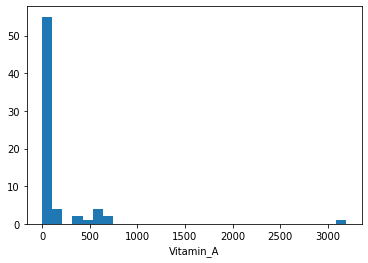

In [16]:
plt.hist(Y,bins=30)
plt.xlabel(nut);

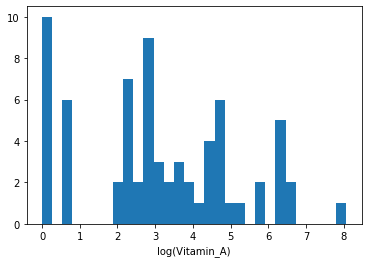

In [17]:
plt.hist(Ylog,bins=30)
plt.xlabel('log('+nut+')');

## Specify Bayesian model

In [19]:
Model_1 = pm.Model()

with Model_1:
    # Intercept
    γ0 = pm.Normal('Intercept', mu=0, tau=0.0001)
    # Observation model
    #σγ = pm.Uniform('Sigma_γ', 0, 100)
    #β0 = pm.Normal('Order', mu=γ0, sd=σγ, shape=nord)
    #pi_tilde = pm.Normal('pi_t', 0, 1, shape=nord)
    #β0 = pm.Deterministic('Order', γ0 + σγ*pi_tilde)
    # Random effect of data-source
    #β01 = pm.Normal('Geography', 0, 1, shape=ngeo) 
    
    #"""
    # Habitat type
    β1_ = pm.Normal('Habitat', 0, tau=0.01, shape=nhabs-1)
    β1 = tt.set_subtensor(tt.zeros(shape=nhabs)[1:], β1_)
    # Climate
    β2_ = pm.Normal('Climate', 0, tau=0.01, shape=nclim-1)
    β2 = tt.set_subtensor(tt.zeros(shape=nclim)[1:], β2_)
    # Maximum Depth
    β3 = pm.Normal('MaxDepth', 0, tau=0.01)
    # Total Length
    β4 = pm.Normal('TL', 0, tau=0.01)
    # Pelagic/demersal
    β5 = pm.Normal('pelagic', 0, tau=0.01)
    # Maximum length
    β6 = pm.Normal('LMax', 0, tau=0.01)
    # Body form
    β7_ = pm.Normal('Body', 0, tau=0.01, shape=nbod-1)
    β7 = tt.set_subtensor(tt.zeros(shape=nbod)[1:], β7_)
    # Growth parameter
    β8 = pm.Normal('K', 0, tau=0.01)
    # Age at maturity
    β9 = pm.Normal('tm', 0, tau=0.01)
    
    # Form of sample
    β10_ = pm.Normal('Form', 0, tau=0.01, shape=nform-1)
    β10 = tt.set_subtensor(tt.zeros(shape=nform)[1:], β10_)
    # Form of prepartion
    β11_ = pm.Normal('Prep', 0, tau=0.01, shape=nprep-1)
    β11 = tt.set_subtensor(tt.zeros(shape=nprep)[1:], β11_)
    # Database used
    β12_ = pm.Normal('Search', 0, tau=0.01, shape=nsearch-1)
    β12 = tt.set_subtensor(tt.zeros(shape=nsearch)[1:], β12_)
    
    #"""
    
    # Mean model
    μ_ = γ0+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5*Pelagic+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β11[Ip]+β12[Is]
    #μ_ = β0[Io]
    
    # Normal - log-Vitamin-A (5)
    μ = μ_
    σ = pm.Uniform('Sigma', lower=0, upper=1000)
    Yi = pm.Normal('Yi', mu=μ, sd=σ, observed=Ylog)
    
    # ST - 
    #μ = μ_
    #ν = pm.Uniform('nu', lower=0, upper=10)
    #σ = pm.Uniform('Sigma', lower=0, upper=1000)
    #Yi = pm.StudentT('Yi', nu=ν, mu=μ, sd=σ, observed=Ylog)
    
    # Gamma model - 
    #μ = tt.exp(μ_)
    #α = pm.Uniform('α', lower=0., upper=100.)
    #Yi = pm.Gamma('Yi', alpha=α, beta=α/μ, observed=Ylog)
    
    # Pareto model - 
    #μ = tt.exp(μ_)
    #Yi = pm.Pareto('Yi', μ, m=min(Y), observed=Y)
    

In [20]:
# Sampling
with Model_1:
    # Draw samples
    trace = pm.sample(5000, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Sigma, Search, Prep, Form, tm, K, Body, LMax, pelagic, TL, MaxDepth, Climate, Habitat, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [01:34<00:00, 233.60draws/s]
The acceptance probability does not match the target. It is 0.8846115481355111, but should be close to 0.8. Try to increase the number of tuning steps.


## Divergence analysis

In [ ]:
def pairplot_divergence(trace, basevar, targetvar, ax=None, divergence=True, color='C3', divergence_color='C2'):
    #theta = trace.get_values(varname=basevar, combine=True)[:, 0]
    theta = trace.get_values(varname=basevar, combine=True)
    logtau = trace.get_values(varname=targetvar, combine=True)
    if not ax:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(theta, logtau, 'o', color=color, alpha=.5)
    if divergence:
        divergent = trace['diverging']
        ax.plot(theta[divergent], logtau[divergent], 'o', color=divergence_color)
    ax.set_xlabel(basevar)
    ax.set_ylabel(targetvar)
    ax.set_title('scatter plot between log('+targetvar+') and '+basevar);
    return ax

In [ ]:
# A small wrapper function for displaying the MCMC sampler diagnostics as above
def report_trace(trace,basevar,targetvar,logscale=False):
    # plot the trace of log(tau)
    pm.traceplot({targetvar: trace.get_values(varname=targetvar, combine=False)});

    # plot the estimate for the mean of log(τ) cumulating mean
    if logscale:
        logtau = np.log(trace[targetvar])
    else:
        logtau = trace[targetvar]
    mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
    plt.figure(figsize=(15, 4))
    #plt.axhline(0.7657852, lw=2.5, color='gray')
    plt.plot(mlogtau, lw=2.5)
    plt.ylim(0, 2)
    plt.xlabel('Iteration')
    plt.ylabel('MCMC mean of log('+targetvar+')')
    plt.title('MCMC estimation of log('+targetvar+')')
    plt.show()

    # display the total number and percentage of divergent
    divergent = trace['diverging']
    print('Number of Divergent %d' % divergent.nonzero()[0].size)
    divperc = divergent.nonzero()[0].size / len(trace) * 100
    print('Percentage of Divergent %.1f' % divperc)

    # scatter plot between log(tau) and theta[0]
    # for the identifcation of the problematic neighborhoods in parameter space
    pairplot_divergence(trace,basevar,targetvar);

In [ ]:
#report_trace(trace,'Intercept','Sigma_γ')

## Summary plots

In [21]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,6.655,1.921,3.126,10.321,0.016,0.011,15090.0,15090.0,15073.0,14038.0,1.0
Habitat[0],0.537,0.800,-0.910,2.077,0.008,0.005,11170.0,10850.0,11195.0,12851.0,1.0
Habitat[1],0.843,0.735,-0.541,2.229,0.006,0.004,13910.0,13855.0,13917.0,14480.0,1.0
Habitat[2],1.045,0.883,-0.634,2.686,0.007,0.005,13942.0,13617.0,13948.0,14560.0,1.0
Habitat[3],0.133,1.178,-2.024,2.371,0.011,0.008,11340.0,11340.0,11355.0,13081.0,1.0
Climate[0],0.613,0.824,-0.926,2.155,0.008,0.006,10529.0,10469.0,10526.0,13104.0,1.0
Climate[1],-0.404,0.697,-1.714,0.909,0.006,0.004,14893.0,13547.0,14942.0,14528.0,1.0
Climate[2],-1.521,0.987,-3.384,0.336,0.008,0.006,17088.0,15520.0,17089.0,15392.0,1.0
MaxDepth,-0.095,0.210,-0.485,0.302,0.002,0.001,12792.0,12320.0,12785.0,14292.0,1.0
TL,-0.840,0.522,-1.822,0.143,0.004,0.003,15695.0,14739.0,15705.0,14066.0,1.0


<Figure size 1224x792 with 0 Axes>

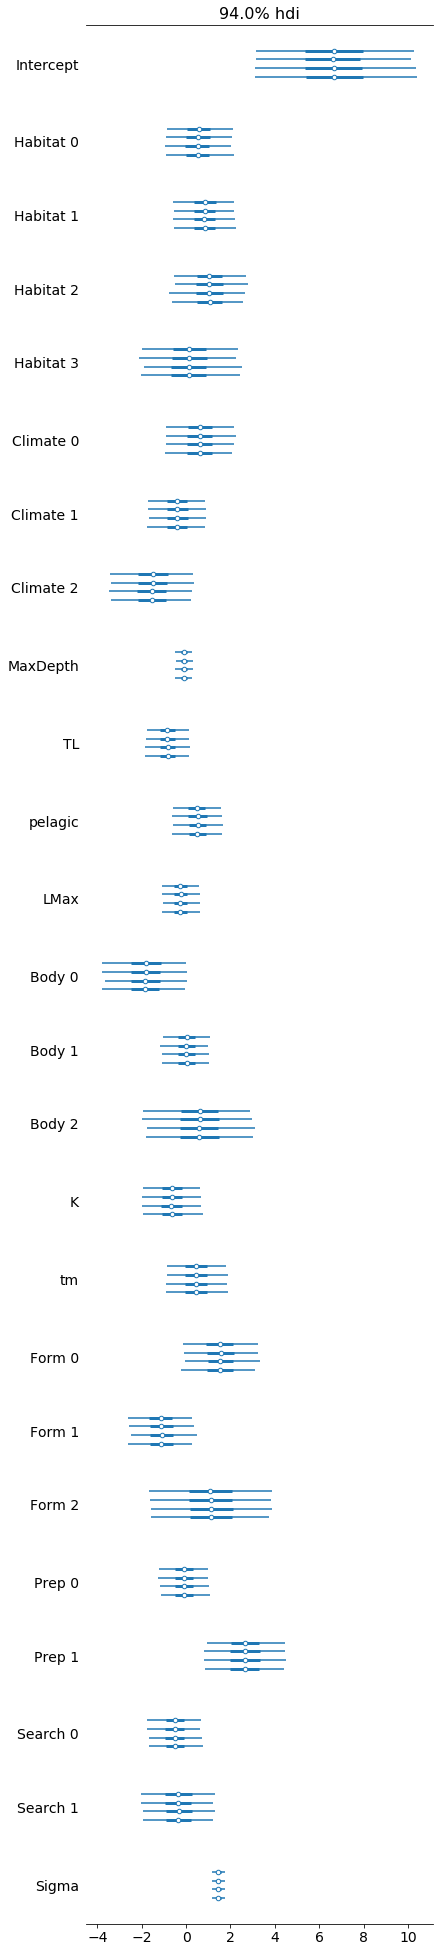

In [22]:
plt.figure(figsize=(17, 11))
pm.forestplot(trace)
plt.savefig('Figure_S3_'+nut+'.jpg',dpi=300);

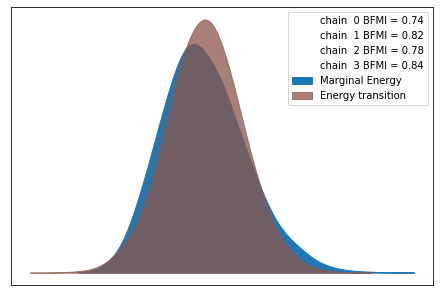

In [23]:
pm.plots.energyplot(trace);

In [24]:
pm.stats.waic(trace, Model_1)

/opt/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1411: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 20000 by 69 log-likelihood matrix

          Estimate       SE
elpd_waic  -135.33     6.40
p_waic       20.19        -

There has been a warning during the calculation. Please check the results.

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [25]:
# Export results 
out = pm.backends.tracetab.trace_to_dataframe(trace)
colnames = np.array(list(out.columns), dtype=object)
# Rename columns
colnames[match(grep('Habitat',list(colnames)),list(colnames))] = Habitat[1:]
colnames[match(grep('Climate',list(colnames)),list(colnames))] = Climate[1:]
colnames[match(grep('Body',list(colnames)),list(colnames))] = Body[1:]
colnames[match(grep('Form',list(colnames)),list(colnames))] = Form[1:]
colnames[match(grep('Prep',list(colnames)),list(colnames))] = Prep[1:]
colnames[match(grep('Search',list(colnames)),list(colnames))] = Search[1:]
# Rename
out.columns = list(colnames)

In [26]:
# Add baseline columns to dataframe
out['demersal'] = 0
out['temperate'] = 0
out['fusiform'] = 0
out['muscle'] = 0
out['wet'] = 0
out['WOS'] = 0

In [41]:
out.to_csv(nut+'_results.csv')

In [28]:
out.head()

,Intercept,pelagic_neritic,benthopelagic,reef_associated,pelagic_oceanic,tropical,subtropical,polar_deep,MaxDepth,TL,...,dry,Expert,FAO,Sigma,demersal,temperate,fusiform,muscle,wet,WOS
0,3.589292,1.343546,0.812058,0.467293,0.697692,0.818352,-1.040860,-2.845884,0.131073,-0.314876,...,2.808710,-0.631690,0.146899,1.321416,0,0,0,0,0,0
1,6.631876,-0.107845,0.657998,1.303049,0.827815,0.589062,-0.077048,-0.176109,-0.348299,-0.556891,...,2.397590,-0.483248,-0.361969,1.233322,0,0,0,0,0,0
2,6.393060,-0.042570,0.062398,1.090143,-0.294196,-1.709887,-2.257977,-2.481923,-0.092180,-0.939311,...,2.938104,0.187429,-0.743588,1.516463,0,0,0,0,0,0
3,7.151549,1.342703,2.000178,1.801603,1.496091,2.844339,0.745530,-0.806688,-0.115130,-0.992864,...,1.418525,-0.886671,-0.180697,1.209272,0,0,0,0,0,0
4,6.893046,1.294565,0.390216,1.824883,0.444959,-1.232223,-1.457893,-1.962698,-0.230896,-0.707761,...,3.689754,-0.028139,-1.177828,1.417180,0,0,0,0,0,0


### Model-checking

In [29]:
ppc = pm.sample_ppc(trace, model=Model_1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 20000/20000 [00:28<00:00, 707.18it/s]


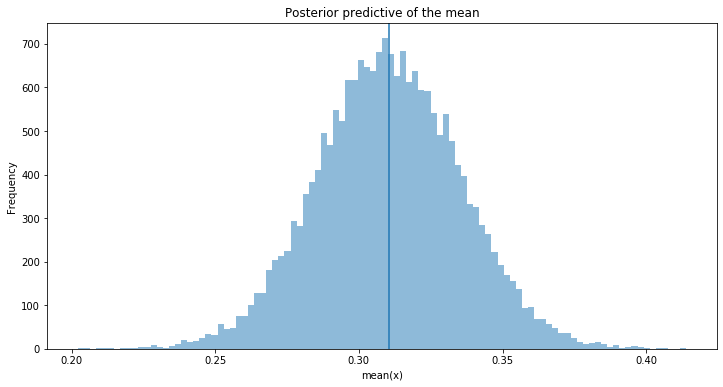

In [30]:
_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean()/10 for n in ppc['Yi']], bins=100, alpha=0.5)
ax.axvline(Ylog.mean()/10)
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency')
plt.savefig('Figure_S4_'+nut+'.jpg',dpi=300);

In [31]:
Ylog[indx[1]]

array([], shape=(0, 69), dtype=float64)

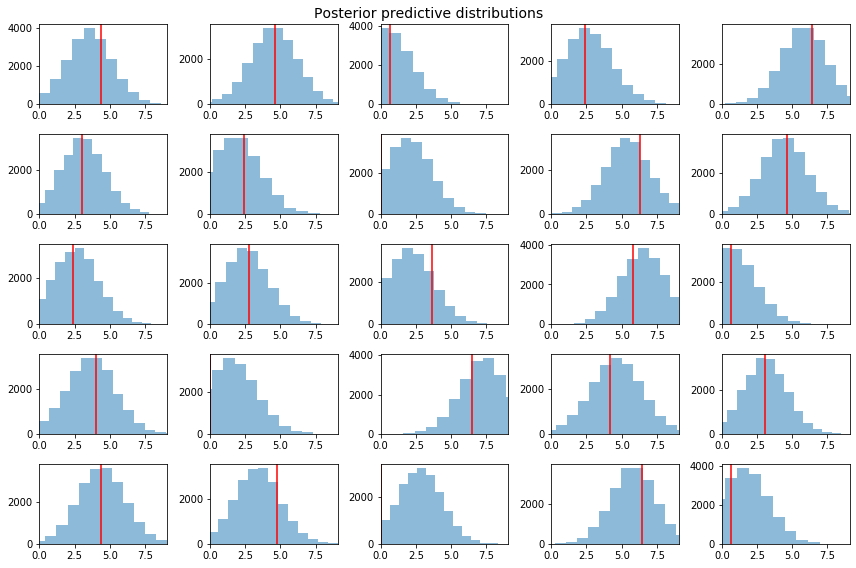

In [32]:
# Setup multipanel figure
nrows, ncols = 5, 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,8))
ax_ = axes.flatten()

# Transform ppc
PPC = ppc['Yi'].T
# Index random observations
indx = np.random.randint(0,len(PPC),size=nrows*ncols)

# Iterate over random samples from ppc
for i in range(nrows*ncols):
    ax1 = ax_[i]
    ax1.hist(PPC[indx[i]], bins=19, alpha=0.5)
    ax1.axvline(Ylog[indx[i]],c='red')
    ax1.set_xlim(0,max(Ylog)+1)

fig.tight_layout()
fig.suptitle('Posterior predictive distributions', fontsize=14)
fig.subplots_adjust(top=0.95)
plt.savefig('Figure_S5_'+nut+'.jpg',dpi=300);

In [33]:
def abline(intercept, slope):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--',c='grey')

In [34]:
Io

array([ 0,  1,  0,  0,  2,  0,  0,  0,  3,  1,  3,  0,  1,  1,  1,  4,  0,
        1,  1,  0,  1,  0,  0,  3,  0,  3,  1,  1,  1,  0,  5,  5,  6,  6,
        0,  0,  0,  0,  1,  0,  0,  0,  7,  0,  0,  0,  1,  0,  1,  8,  1,
        6,  8,  5,  9,  0, 10,  1,  1,  0,  0,  3,  0,  0,  0,  0,  4,  0,
        3])

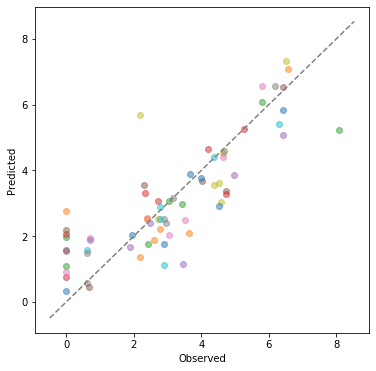

In [35]:
plt.subplots(figsize=(6, 6))
nobs = len(Ylog)
#ocol = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

# Iterate over random samples from ppc
for i in range(nobs):
    plt.scatter(Ylog[i], np.median(PPC[i]), alpha=0.5)

plt.xlabel('Observed')
plt.ylabel('Predicted')

abline(0,1)
    
fig.tight_layout()
plt.savefig('Figure_S6_'+nut+'.jpg',dpi=300);

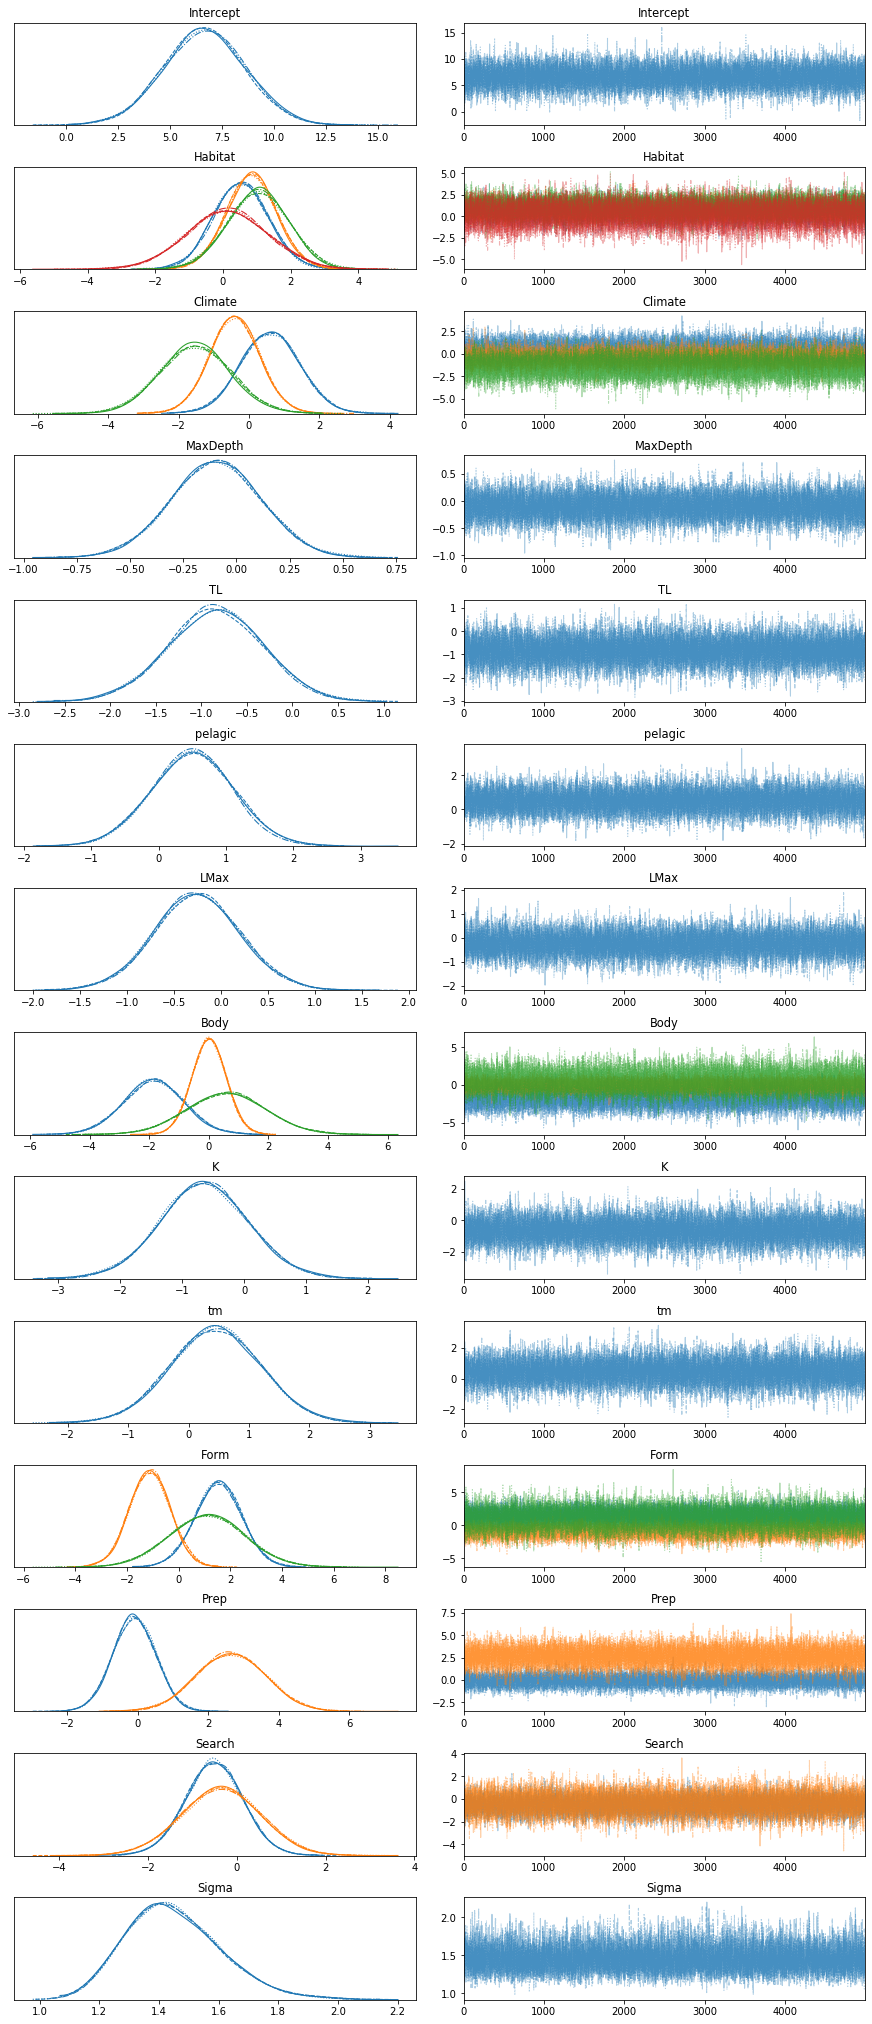

In [36]:
pm.traceplot(trace)
plt.savefig('Figure_S2_'+nut+'.jpg',dpi=300);

In [37]:
Ig[Ylog==0]

array([0, 0, 0, 0, 0, 0, 3, 3, 9, 9])

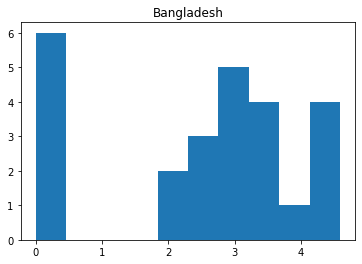

In [38]:
plt.hist(Ylog[Ig==0])
plt.title(Geog[0]);

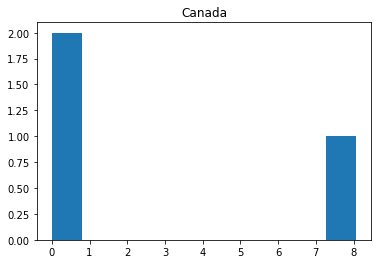

In [39]:
plt.hist(Ylog[Ig==3])
plt.title(Geog[3]);

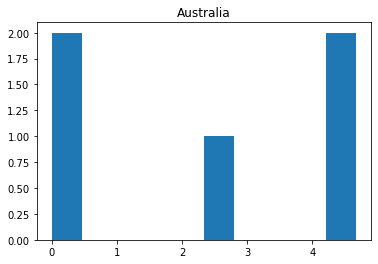

In [40]:
plt.hist(Ylog[Ig==9])
plt.title(Geog[9]);